# Etude de cas

- Application des 2 méthodes (ACP et classification) 

#### Données 

[`pendigits`](http://archive.ics.uci.edu/ml/datasets/pen-based+recognition+of+handwritten+digits) de l'UCI Machine Learning Repository

- Tracé des chiffres de 0 à 9 par plusieurs personnes

- Pour chaque tracé, coordonnées $(X, Y)$ de 8 points et le chiffre tracé

#### Objectifs

- Rechercher les différentes façons d'écrire chaque chiffre

## Librairies et fonction `plot_dendogram()`

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
%matplotlib inline

## Importation des données

In [2]:
url_base = "http://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/"
pen_tes = pandas.read_csv(url_base + "pendigits.tes", header=None)
pen_tra = pandas.read_csv(url_base + "pendigits.tra", header=None)
pen = pen_tes.copy().append(pen_tra, ignore_index = True)
print("Dimensions des données : ", pen.shape)
pen.head()

Dimensions des données :  (10992, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,88,92,2,99,16,66,94,37,70,0,0,24,42,65,100,100,8
1,80,100,18,98,60,66,100,29,42,0,0,23,42,61,56,98,8
2,0,94,9,57,20,19,7,0,20,36,70,68,100,100,18,92,8
3,95,82,71,100,27,77,77,73,100,80,93,42,56,13,0,0,9
4,68,100,6,88,47,75,87,82,85,56,100,29,75,6,0,0,9


- Noms des variables pas renseignés : $(x^j, y^j)_{j=1,\ldots,8}$ et le chiffre

## Création du vecteur des noms de variables

In [3]:
a = [c+n for c, n in zip(["x", "y"] * 8, [str(j) for j in range(1, 9) for i in range(2)])]
a.append("chiffre")
print(a)

['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'chiffre']


### Renommage des colonnes avec ce vecteur

In [4]:
pen.columns = a
pen.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,chiffre
0,88,92,2,99,16,66,94,37,70,0,0,24,42,65,100,100,8
1,80,100,18,98,60,66,100,29,42,0,0,23,42,61,56,98,8
2,0,94,9,57,20,19,7,0,20,36,70,68,100,100,18,92,8
3,95,82,71,100,27,77,77,73,100,80,93,42,56,13,0,0,9
4,68,100,6,88,47,75,87,82,85,56,100,29,75,6,0,0,9


## Création de vecteurs utiles pour la suite

- Dans la suite : besoin d'accéder aux $(x^j)$ uniquement, ou aux $(y^j)$, voire aux deux
- Création des vecteurs avec les noms de variables

In [5]:
xN = ["x" + str(i + 1) for i in range(8)]
print(xN)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']


In [6]:
yN = ["y" + str(i + 1) for i in range(8)]
print(yN)

['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8']


In [7]:
xyN = [a + b for a,b in zip(["x", "y"] * 8, [str(i + 1) for i in range(8) for j in range(2)])]
print(xyN)

['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8']


## Représentation graphique d'un tracé

- Données graphiques $\rightarrow$ Représenter le premier tracé, qui est un $8$

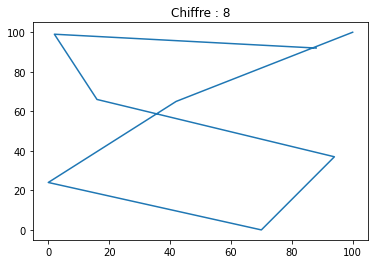

In [8]:
x = pen.loc[0, xN]
y = pen.loc[0, yN]
chiffre = pen.loc[0, "chiffre"]
plt.plot(x, y)
plt.title("Chiffre : " + str(chiffre))
plt.show()

## Création d'un fonction `dessin()`

- Utilisation régulière de ce code $\rightarrow$ stockage dans une fonction nommée `dessin()`

- Paramètres :
    - les $x^j$ et les $y^j$
    - le chiffre
    - un graphique pour placer le dessin (utile pour plusieurs représentations de chiffres)

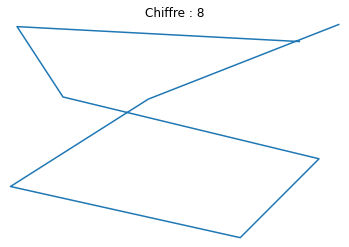

In [9]:
def dessin(p, x, y, chiffre):
    p.plot(x, y)
    p.set_title("Chiffre : " + str(chiffre))
    p.axis("off")
    p.set_xlim([-1, 101])
    p.set_ylim([-1, 101])

fig, ax = plt.subplots()
dessin(ax, x, y, chiffre)

## Création d'une liste

- Création d'une liste de `DataFrame`, un pour chaque chiffre
    - Fonction `query()` : sélectionner des lignes d'un `DataFrame` en fonction d'une condition (ici, chiffre égal 0, 1, ..., 9)
    - Pour éviter les problèmes d'index plus tard : les réinitialiser pour chaque `DataFrame`, avec la fonction `reset_index()`, en mettant `drop` à vrai
        - Ceci permet d'oublier les numéros de ligne du `DataFrame` global et que ceux-ci recommencent de 0 pour chaque sous-ensemble.

In [10]:
sub = [pen.query("chiffre == " + str(i)).reset_index(drop = True) for i in range(10)]

## Représentation du premier tracé de chaque chiffre

- Représenter chaque premier exemple de chaque chiffre

- Pour cela : 
    - Recherche de la première ligne (`index = 0`) pour chaque sous-ensemble précédemment créé
    - Pour simplifier le travail ensuite, renvoi pour chaque chiffre, de trois éléments : les $x^j$, les $y^j$ et le chiffre.

In [11]:
sub_first_xyc = [[s.loc[0, xN], s.loc[0, yN], s.loc[0, "chiffre"]] for s in sub]

## Représentation du premier tracé de chaque chiffre

- Création d'une figure (en spécifiant la taille)

- Pour chaque chiffre, ajout d'un graphique à la figure avec la fonction `add_subplot()`
    - Trois paramètres : le nombre de lignes, le nombre de colonnes et le numéro de placement du prochain graphique

- Réalisation facilité par l'utilisation de la fonction `dessin()` et de l'objet `subxyc`

## Représentation du premier tracé de chaque chiffre



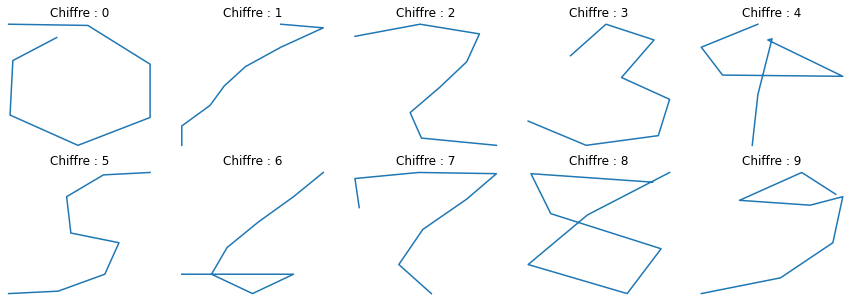

In [12]:
fig = plt.figure(figsize = (15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    dessin(ax, sub_first_xyc[i][0], sub_first_xyc[i][1], sub_first_xyc[i][2])

## Calcul des coordonnées moyennes

- Calcul des coordonnées moyennes pour représenter le *tracé moyen* de chaque chiffre

In [13]:
cmoy = pen.groupby("chiffre").mean().round(2)
cmoy

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8
chiffre,,,,,,,,,,,,,,,,
0,35.37,86.06,11.58,58.31,14.94,19.60,51.17,7.29,85.94,31.30,89.29,68.49,59.01,89.31,22.10,75.24
1,14.70,61.39,44.35,77.94,69.86,89.51,77.50,79.80,67.64,54.06,47.80,32.66,44.60,16.16,59.91,1.38
2,18.39,76.95,42.13,99.39,67.46,79.76,51.28,46.05,19.83,19.38,11.64,9.09,53.06,5.25,98.71,4.17
3,24.78,84.06,56.66,99.52,86.64,84.69,64.53,60.59,82.13,43.22,90.88,17.26,50.01,2.28,3.47,6.24
4,42.96,99.54,22.13,79.38,5.75,51.16,42.83,40.47,85.10,49.56,86.30,59.72,70.99,31.45,62.60,0.00
5,41.24,90.94,42.60,75.83,57.31,59.18,36.46,29.36,26.18,33.15,37.64,50.24,42.83,57.69,59.46,60.31
6,87.52,98.72,51.75,86.72,20.71,58.48,6.94,26.93,32.61,3.14,81.11,11.02,61.57,30.54,11.00,23.35
7,3.50,91.01,45.37,98.25,78.85,80.76,71.27,47.47,52.73,14.93,33.60,18.47,39.51,33.80,81.14,34.31
8,56.95,82.08,39.83,79.62,51.81,51.93,50.56,24.22,35.25,17.07,39.93,36.90,67.78,68.49,49.00,81.40


## Récriture de la fonction `dessin()`

- Amélioration ici de la fonction pour ajouter la possibilité de mettre les points (de 1 à 8)

In [14]:
def dessin(p, x, y, chiffre, pos = False, titre = "Chiffre"):
    p.plot(x, y)
    if (pos):
        for i in range(8):
            p.text(x[i], y[i], str(i+1), 
                   va = "center", ha = "center", weight = "bold", size = "x-large")
    p.set_title(titre + " : " + str(chiffre))
    p.axis("off")
    p.set_xlim([-1, 101])
    p.set_ylim([-1, 101])

## Représentation des *chiffres moyens*

- Les chiffres 0, 1, 2, 3, 4, 6 semblent cohérents ;
- Le chiffre 8 paraît concentré sur la zone centrale ;
- Le chiffre 7, bien que presque reconnaissable, semble étonnant ;
- Les chiffres 5 et 9 sont difficilement reconnaissables.

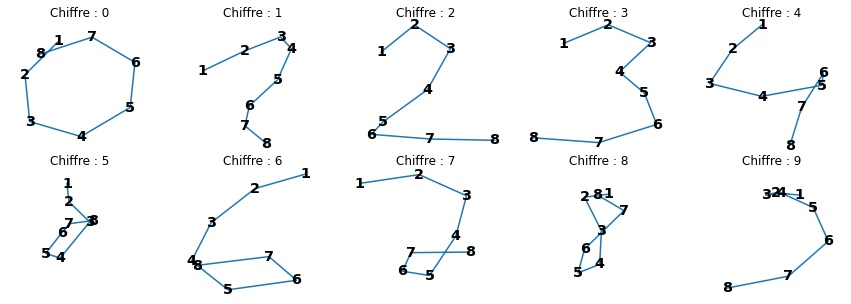

In [15]:
fig = plt.figure(figsize = (15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    dessin(ax, cmoy.loc[i,xN], cmoy.loc[i,yN], str(i), pos = True)

## Représentation des tracés sur un plan en 2D

### sur données originales

- Ensemble de variables avec la même étendue
- Semble logique de faire sur les données originales

In [16]:
pca_original = PCA()
pca_original.fit(pen.loc[:,xyN])
pen_original_pca = pca_original.transform(pen.loc[:,xyN])
pen_original_df = pandas.DataFrame({
    "Dim1" : pen_original_pca[:,0], 
    "Dim2" : pen_original_pca[:,1],
    "Chiffre" : pen["chiffre"]
})

## Représentation des tracés sur un plan en 2D

### sur données originales

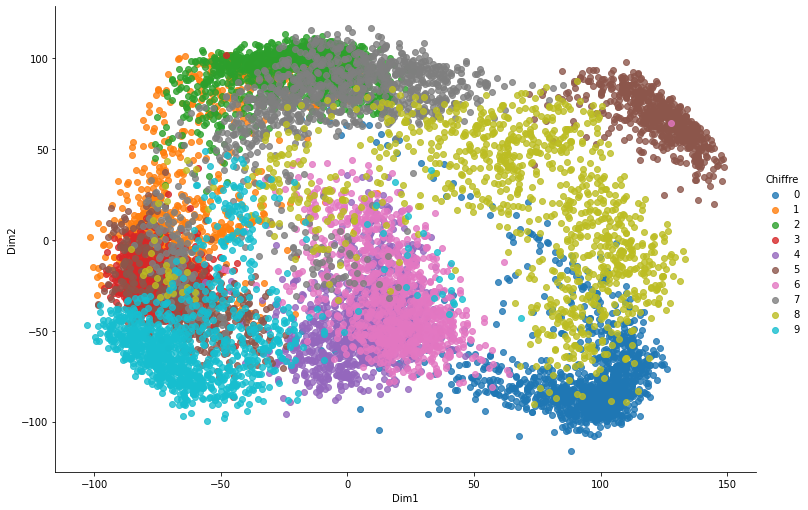

In [17]:
seaborn.lmplot(data = pen_original_df, x = "Dim1", y = "Dim2", hue = "Chiffre",
              fit_reg = False, height = 7, aspect = 1.5)
plt.show()

## Représentation des tracés sur un plan en 2D

### sur données originales

- 2, 3, 4 et 6 : regroupés sur une zone restreinte ;
- 1, 5 (particulièrement), 7, 8 et 9 : avec groupes séparés ;
- 0 : forme allongée courbe.

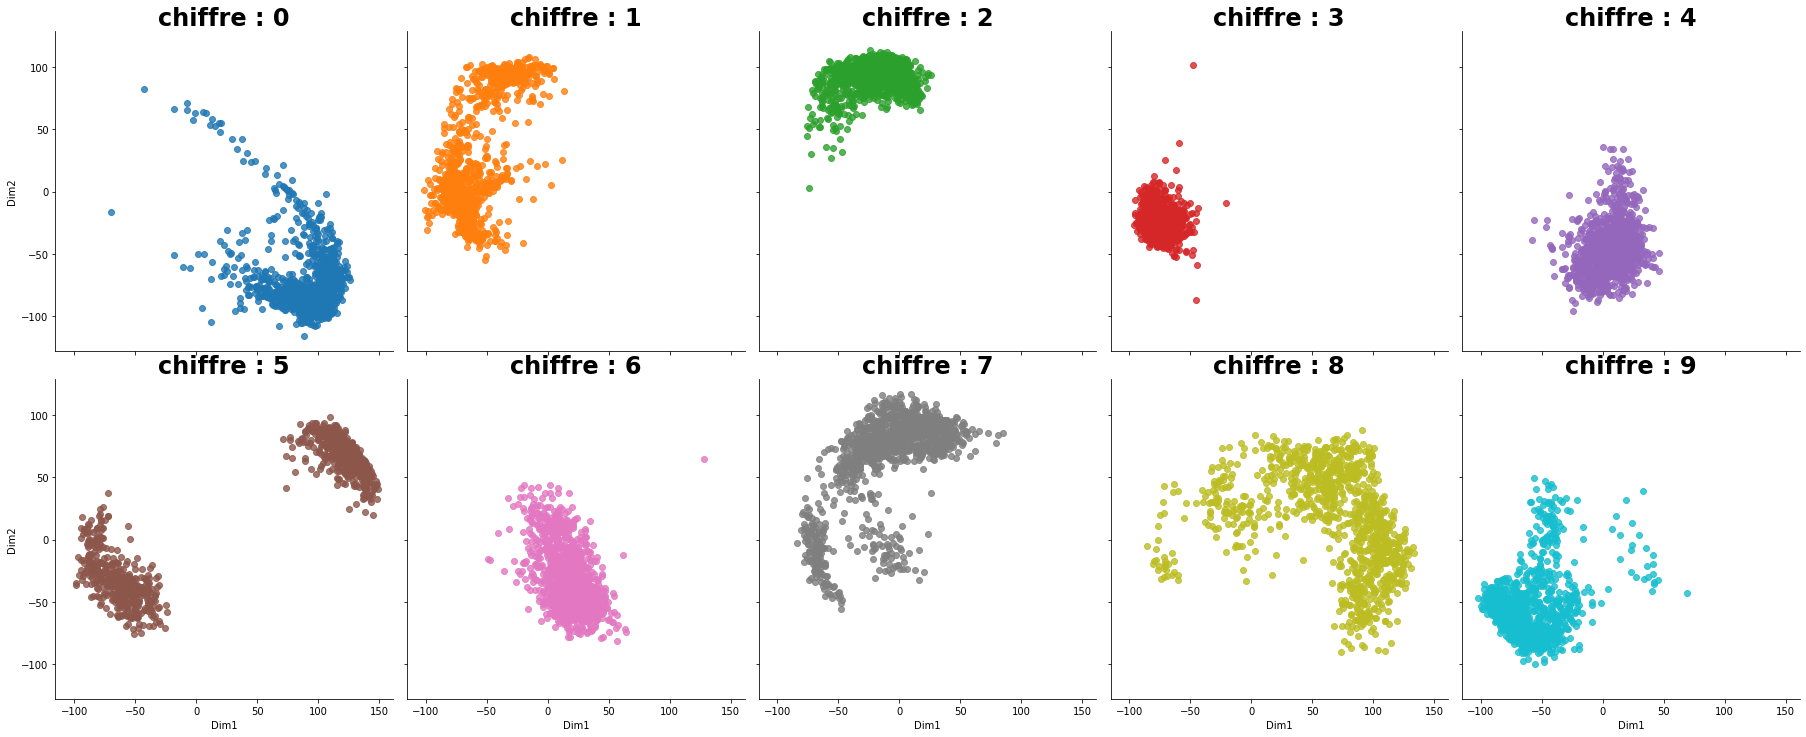

In [18]:
g = seaborn.lmplot(data = pen_original_df, x = "Dim1", y = "Dim2", hue = "Chiffre", 
               col = "Chiffre", col_wrap = 5, fit_reg = False)
g.set_titles(col_template = "chiffre : {col_name}", fontweight = "bold", size = 24)
plt.show()

## Représentation des tracés sur un plan en 2D

### sur données standardisées

- Bien évidemment possible d'appliquer l'ACP sur les données standardisées

In [19]:
pca_scale = PCA()
pca_scale.fit(scale(pen.loc[:,xyN]))
pen_scale_pca = pca_scale.transform(scale(pen.loc[:,xyN]))
pen_scale_df = pandas.DataFrame({
    "Dim1" : pen_scale_pca[:,0], 
    "Dim2" : pen_scale_pca[:,1],
    "Chiffre" : pen["chiffre"]
})

## Représentation des tracés sur un plan en 2D

### sur données standardisées

- Forme sphérique due aux valeurs entre 0 et 100 d'une part, et à la standardisation d'autre part

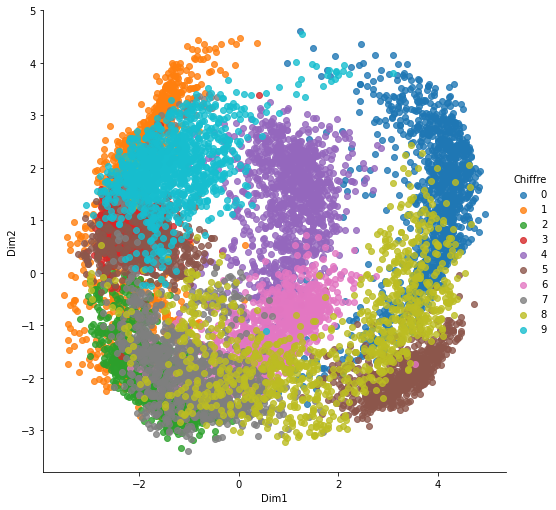

In [20]:
seaborn.lmplot(data = pen_scale_df, x = "Dim1", y = "Dim2", hue = "Chiffre",
              fit_reg = False, height = 7, aspect = 1)
plt.show()

## Représentation des tracés sur un plan en 2D

### sur données standardisées

- 2, 3, 4 et 6 : aussi regroupés sur une zone restreinte ;
- 1, 5 (particulièrement), 7, 8 et 9 : encore des groupes séparés ;
- 0 : toujours une forme allongée courbe.

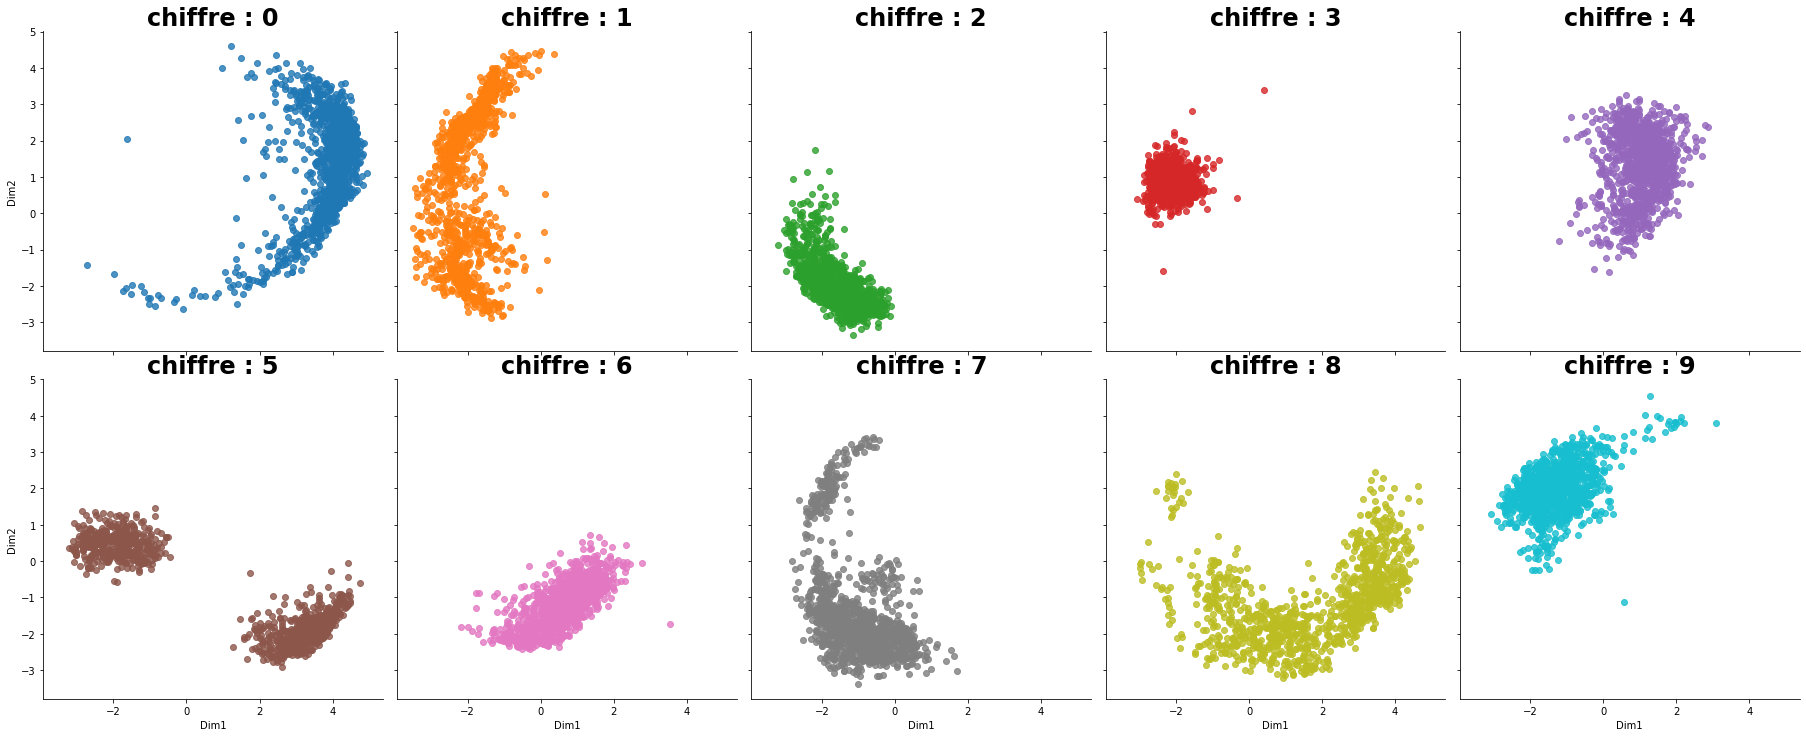

In [21]:
g = seaborn.lmplot(data = pen_scale_df, x = "Dim1", y = "Dim2", hue = "Chiffre", 
               col = "Chiffre", col_wrap = 5, fit_reg = False)
g.set_titles(col_template = "chiffre : {col_name}", fontweight = "bold", size = 24)
plt.show()

## Recherche des différentes manières d'écrire chaque chiffre

### Définition de 2 fonctions

#### `recherche(chiffre)`

- Recherche du nombre de classes
- Représentation du dendrogramme de la CAH et l'évolution de l'inertie intra-classe avec $k$-means

#### `application(chiffre, nb_classes)`

- Application du nombre de classes
- Lancement de $k$-means 
- Représentation double
    - Sur le plan factoriel
    - Tracé moyen de chaque classe

## Fonction `recherche(chiffre)`

In [22]:
def recherche(chiffre):
    # Restriction aux données d'intérêts + standardisation (nécessaire pour CAH et k-means)
    pen_chiffre = pen.query("chiffre == " + str(chiffre)).drop(columns = "chiffre")
    pen_chiffre_scale = scale(pen_chiffre)
    
    # Réalisation de la CAH avec affichage du dendrogramme
    fig = plt.figure(figsize = (15, 5))
    hac = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    hac.fit(pen_chiffre_scale)
    plot_dendrogram(hac, ax = fig.add_subplot(1, 2, 1))

    # Réalisation de k-means et affichage de l'évolution de l'intertie intra-classe
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters = k, init = "random", n_init = 20).fit(pen_chiffre_scale)
        inertia = inertia + [kmeans.inertia_]
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(1, 11), inertia)

## Fonction `application(chiffre, nb_classes)`

In [23]:
def application(chiffre, nb_classes):
    # Restriction aux données d'intérêts + standardisation (nécessaire pour CAH et k-means)
    pen_chiffre = pen.query("chiffre == " + str(chiffre)).drop(columns = "chiffre")
    pen_chiffre_scale = scale(pen_chiffre)
    
    # Réalisation de k-means avec affichage du nombre de tracés pour chaque classe, 
    # des tracés sur le plan factoriel et des tracés moyens de chaque classe
    kmeans = KMeans(n_clusters = nb_classes)
    kmeans.fit(pen_chiffre_scale)
    
    pca_chiffre = pen_scale_df.query("Chiffre == " + str(chiffre)) \
                              .assign(classe = kmeans.labels_)
    g = seaborn.lmplot(data = pca_chiffre, x = "Dim1", y = "Dim2", hue = "classe", 
                   col = "classe", fit_reg = False)
    g.set(xlim=(-4, 5), ylim=(-4,5))
    
    km_centres = pen_chiffre.assign(classe = kmeans.labels_).groupby("classe").mean()
    fig = plt.figure(figsize = (18, 5))
    for k in range(nb_classes):
        nbk = numpy.sum([i == k for i in kmeans.labels_])
        ax = fig.add_subplot(1, nb_classes, k + 1)
        dessin(ax, km_centres.loc[k,xN], km_centres.loc[k,yN], str(k), 
               pos = True, titre = "Classe (nb : " + str(nbk) + ")")

## Chiffre 0

### Recherche

- Choix de $k=4$ classes

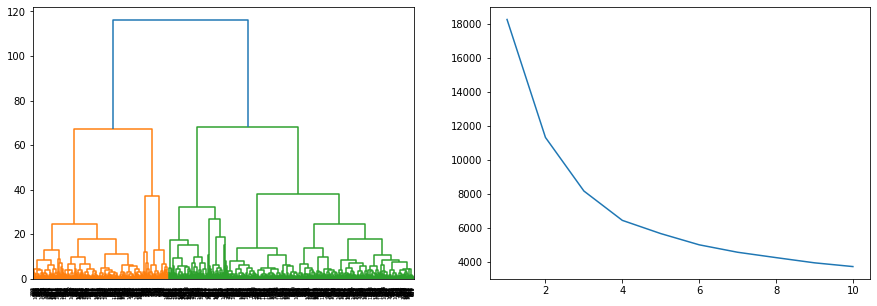

In [24]:
recherche(0)

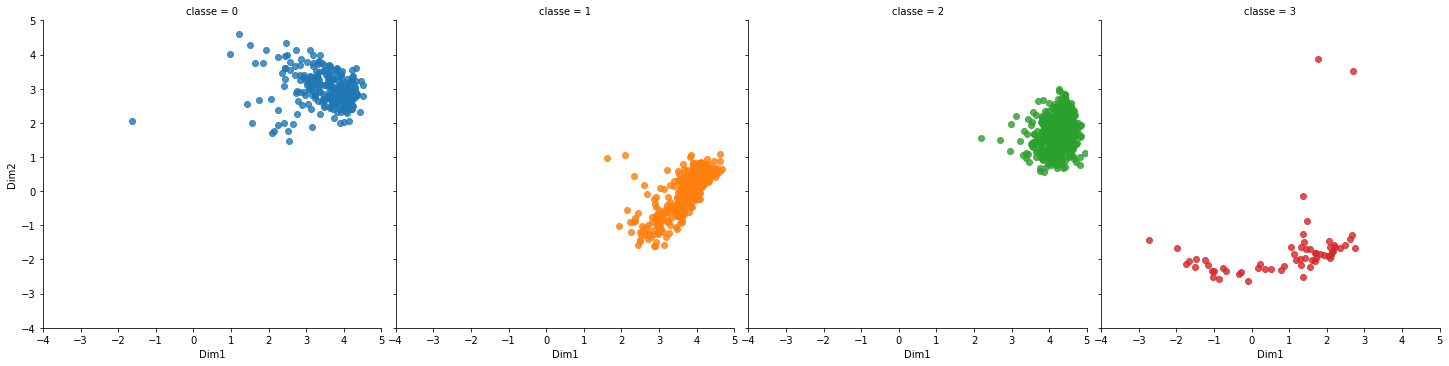

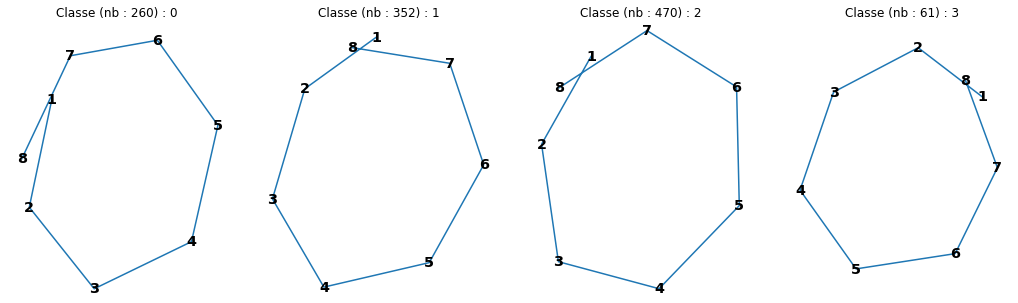

In [25]:
application(0, 4)

## Chiffre 0

### Application

- Représentations identique, différence entre les 4 types de tracés venant du démarrage

## Chiffre 1

### Recherche

- On peut hésiter entre 2 et 4 classes

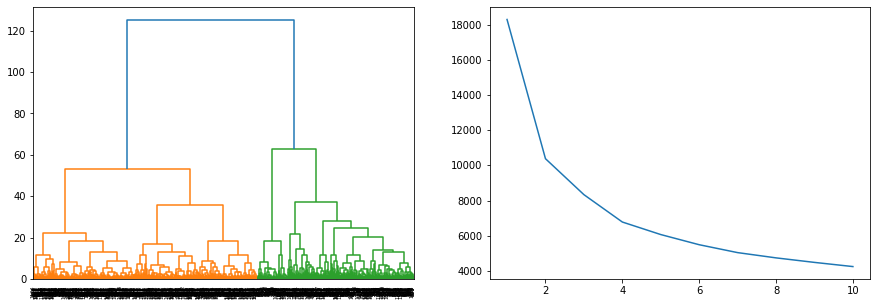

In [26]:
recherche(1)

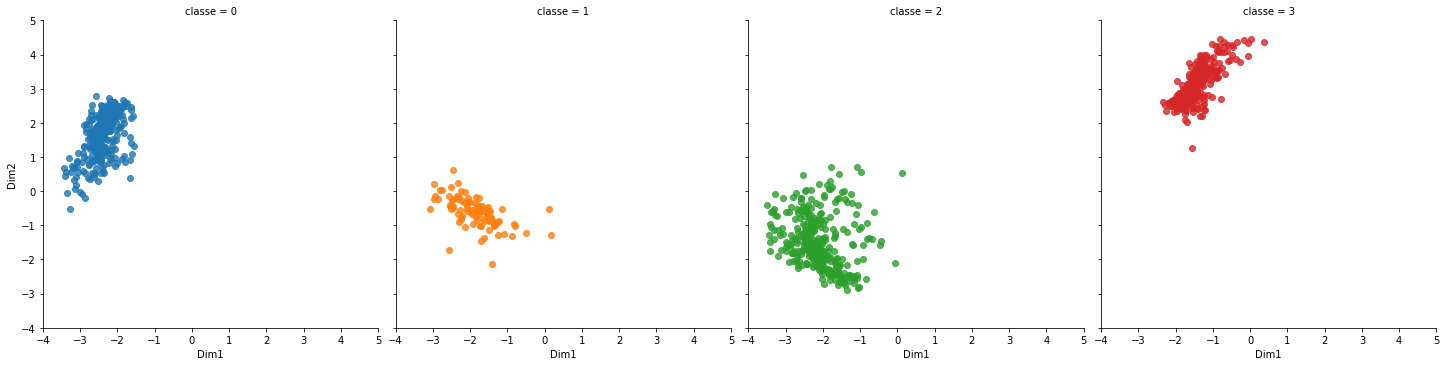

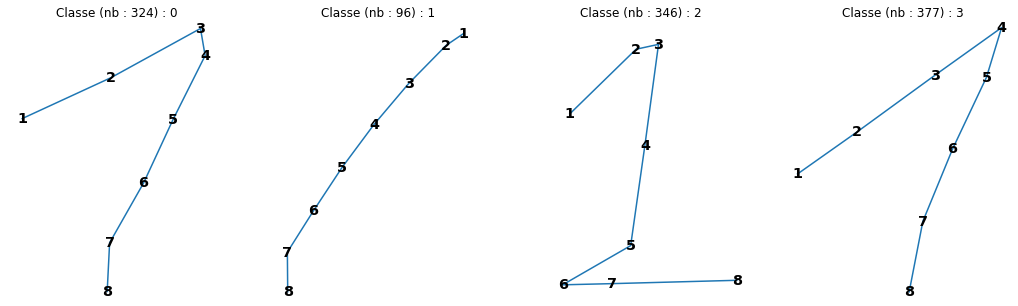

In [27]:
application(1, 4)

## Chiffre 1

### Application

Avec 4 classes, on est plus fin sur les distinctions entre les types de tracé :

- deux classes ont un tracé similaire
- une classe concerne les tracés avec une barre en bas ;
- une concerne elle les tracés en un seul trait vertical.

## Chiffre 2

### Recherche

- Il ne semble pas vraiment y avoir plus d'une classe

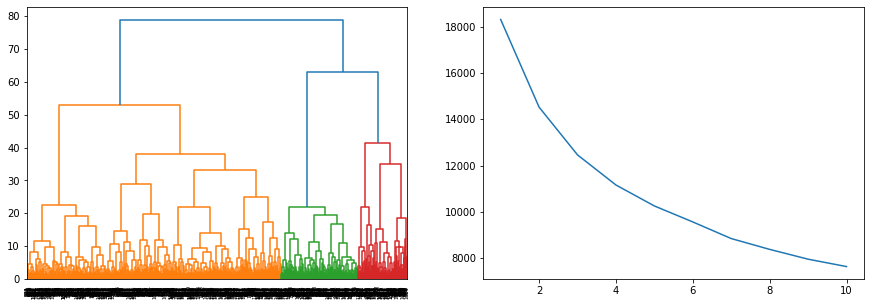

In [28]:
recherche(2)

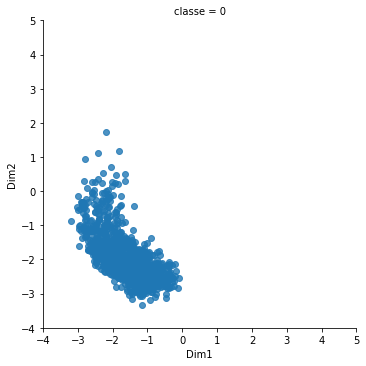

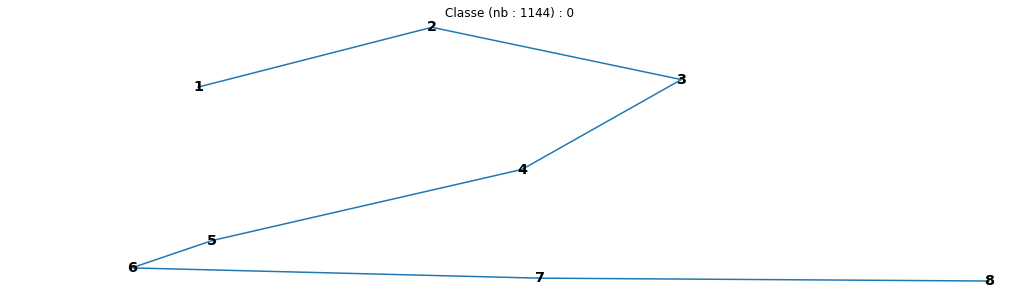

In [29]:
application(2, 1)

## Chiffre 2

### Application

- En testant 2, 3 ou 4 classes (qui peuvent se justifier via la CAH), on remarque que les tracés moyens des classes sont tous identiques.

## Chiffre 3

### Recherche

- Il ne semble pas vraiment y avoir plus d'une classe

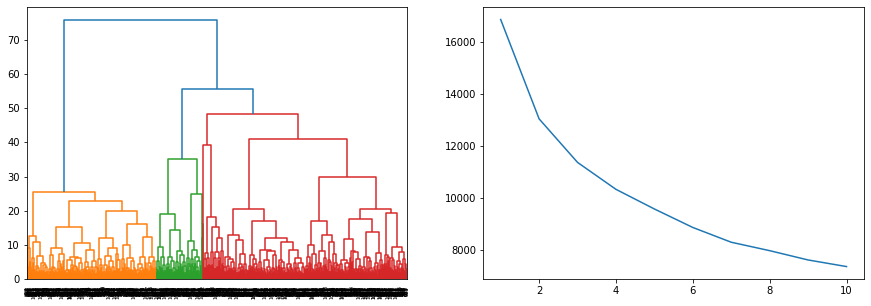

In [30]:
recherche(3)

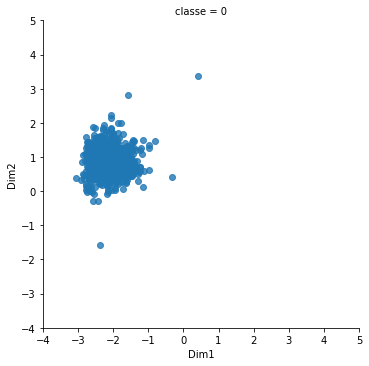

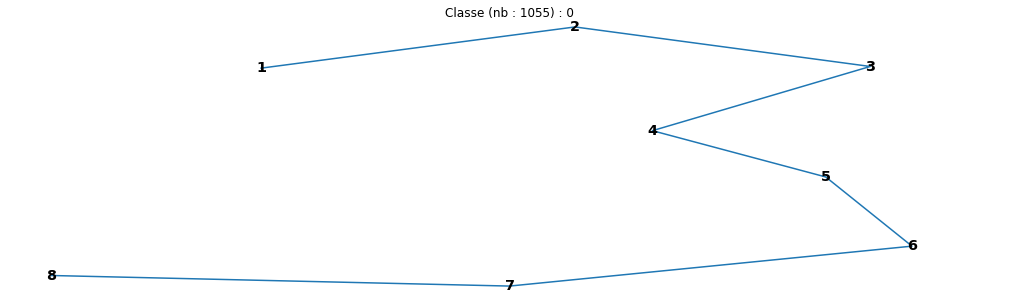

In [31]:
application(3, 1)

## Chiffre 3

### Application

- En testant 2 classes (qui peut se justifier via la CAH), on remarque que les tracés moyens des 2 classes sont identiques.

## Chiffre 4

### Recherche

- Ici, seule une partition en 3 classes semble avoir du sens

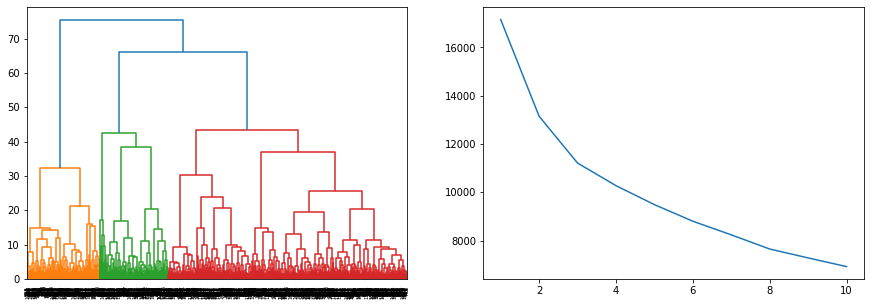

In [32]:
recherche(4)

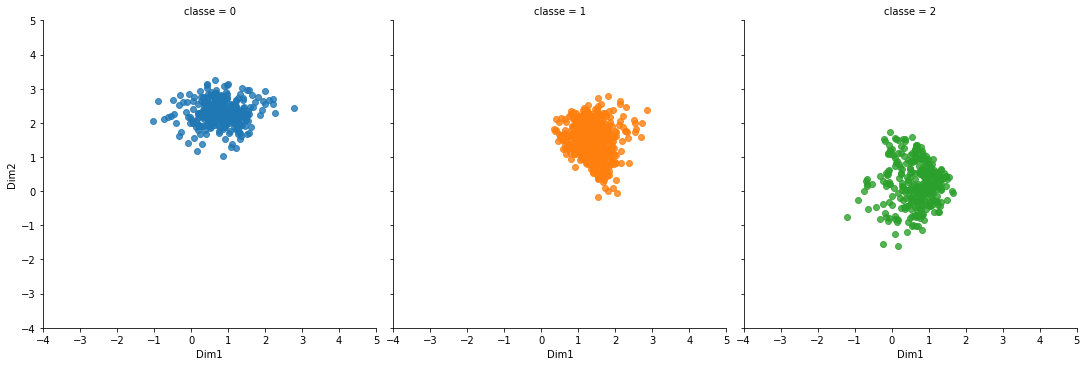

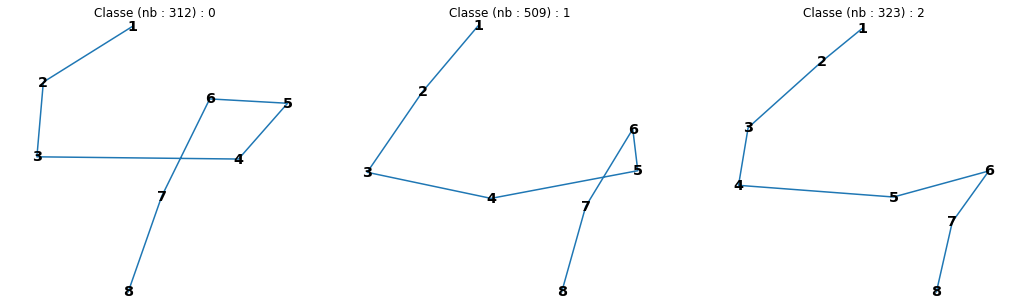

In [33]:
application(4, 3)

## Chiffre 4

### Application

- Les tracés sont assez similaires et divergent entre eux principalement sur la deuxième partie du dessin.

## Chiffre 5

### Recherche

- Il semble assez clair qu'il y a 2 classes très différentes

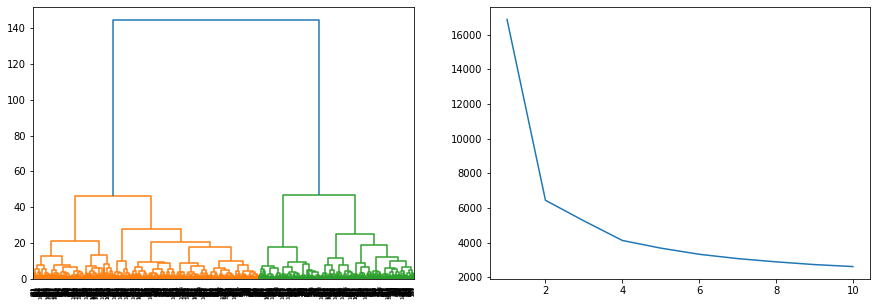

In [34]:
recherche(5)

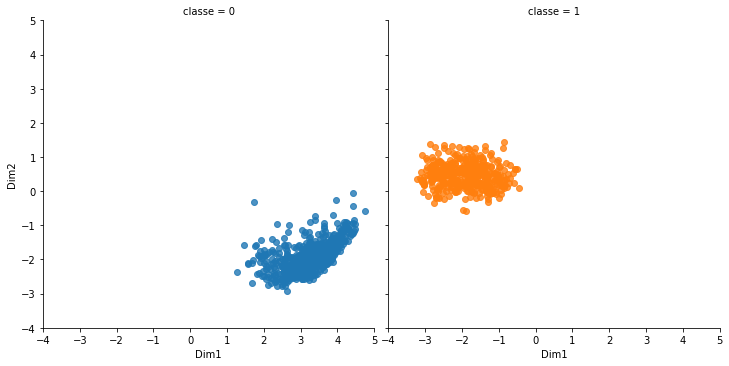

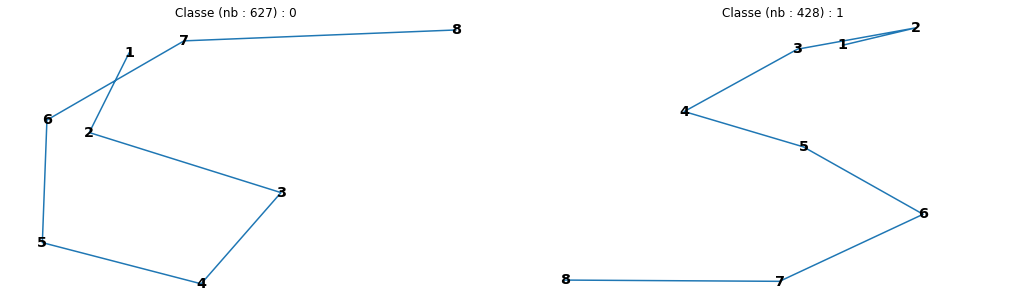

In [35]:
application(5, 2)

## Chiffre 5

### Application

- Une classe concerne les tracés en un seul mouvement, l'autre concernant les tracés en 2 mouvements (avec soulèvement du stylo donc).

## Chiffre 6

### Recherche

- Il ne semble pas vraiment y avoir plus d'une classe, même si la recherche tend à choisir 2 classes

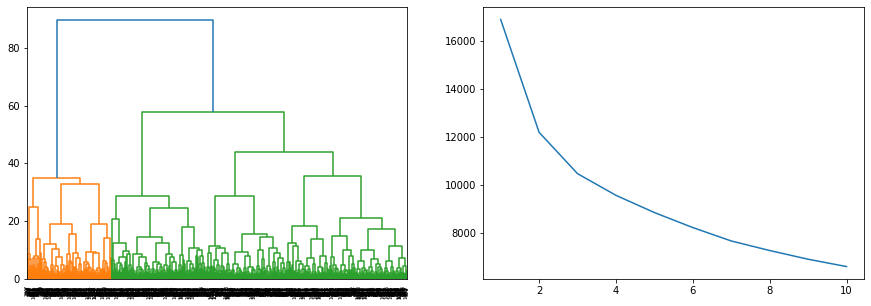

In [36]:
recherche(6)

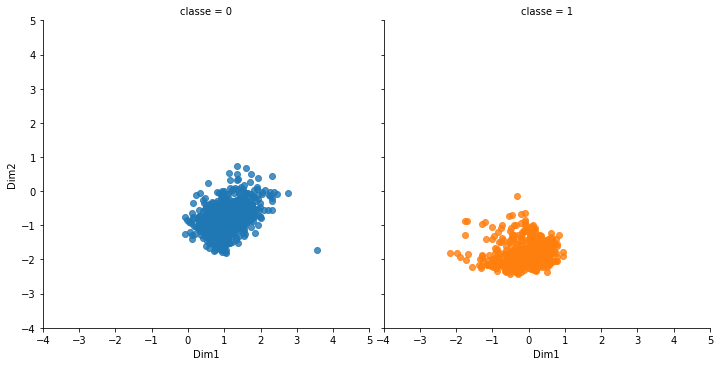

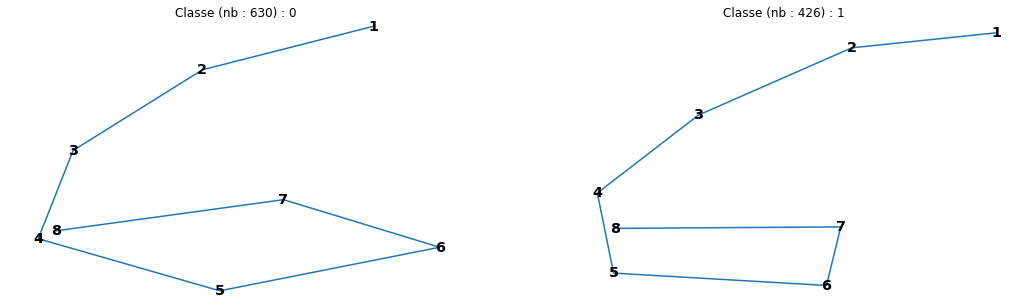

In [37]:
application(6, 2)

## Chiffre 6

### Représentation

- Les 2 classes ont des tracés moyens quasiment identiques.

## Chiffre 7

### Recherche

- On peut hésiter entre 2 et 3 classes

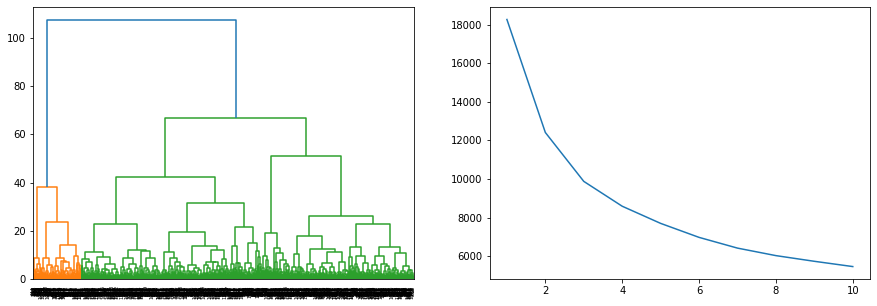

In [38]:
recherche(7)

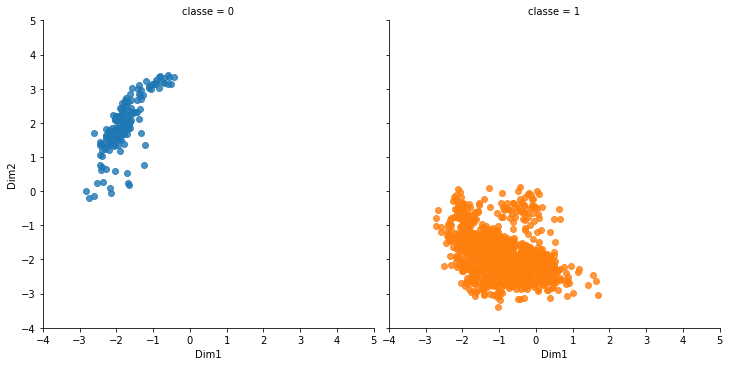

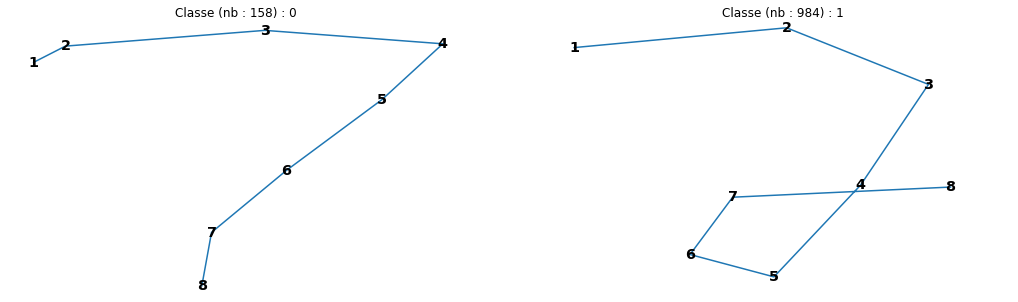

In [39]:
application(7, 2)

## Chiffre 7

### Application

- La différence est flagrante entre les deux :
    - une classe majoritaire contient les tracés avec une barre au milieu ;
    - une classe minoritaire contient les tracés sans barre au milieu.

## Chiffre 8

### Recherche

- On pourrait être tenter de choisir 2 ou 3 classes

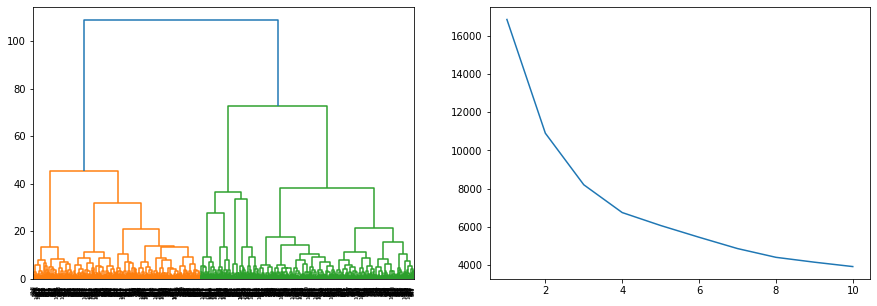

In [40]:
recherche(8)

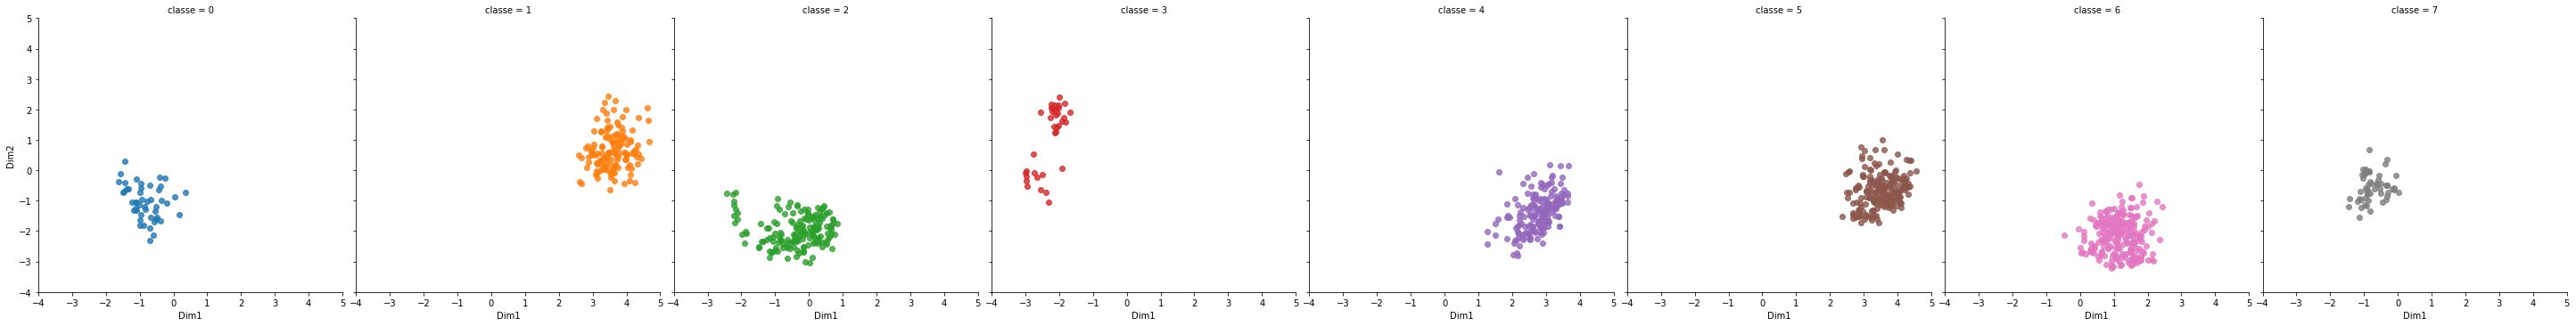

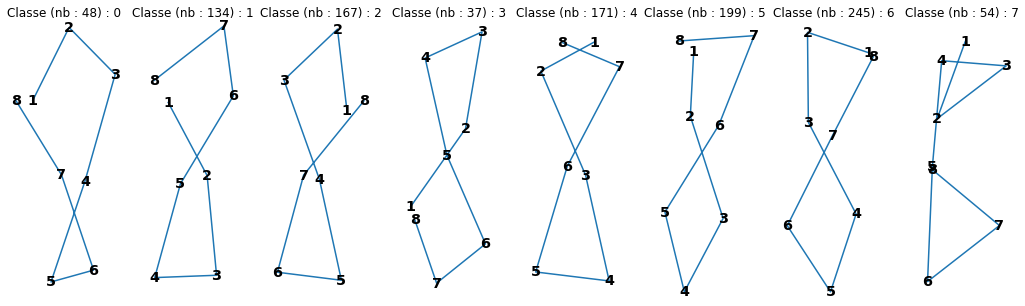

In [41]:
application(8, 8)

## Chiffre 8

### Application

- La partition en 8 classes, bien que sûrement trop fine, dégagent tout de même des profils différents de tracés :
    - en partant du haut (assez classiquement), avec des points de départs différents ;
    - en partant du bas (une classe) ;
    - en réalisant 2 ronds (une classe) ;
    - en tournant dans l'autre sens pour une classe.

## Chiffre 9

### Recherche

- Le choix de 4 classes semble pertinent

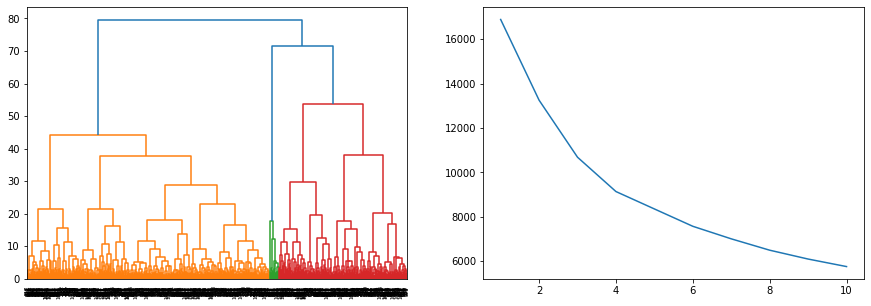

In [42]:
recherche(9)

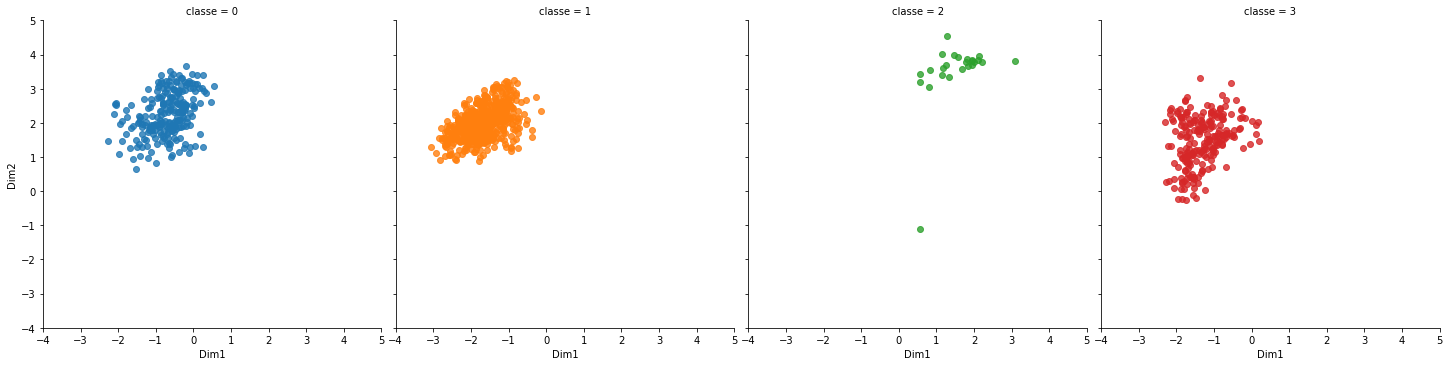

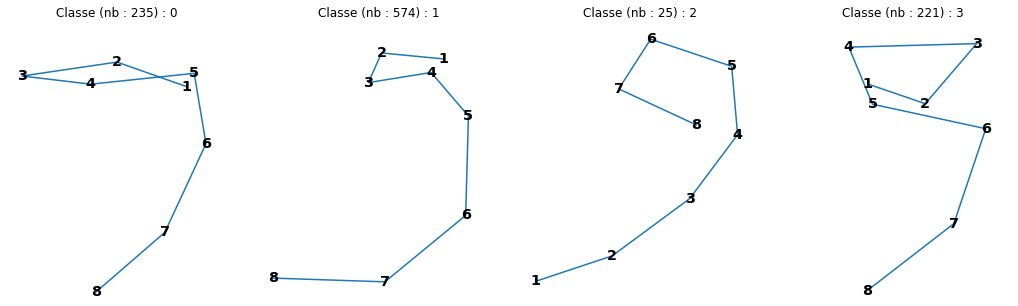

In [43]:
application(9, 4)

## Chiffre 9

### Application

- Les tracés sont ainsi assez différents :
    - une classe avec des tracés partant du bas ;
    - une classe avec un rond assez prononcé au début, puis la descente ;
    - deux classes assez proches dans la réalisation au début, et qui divergent sur la fin du dessin.

## Conclusion

- Pour certains chiffres : plusieurs façons de réaliser leur tracé
    - parfois de façon très nette

- Pour d'autres : un seul tracé
    - avec quelque fois des ajustements

## Mais que faire de ces informations?

Processus de Machine Learning usuel

- Importation et nettoyage des données (étape prenant beaucoup de temps)

- Découverte des données **$\rightarrow$ Apprentissage non-supervisé**
    - Statistiques descriptives
    - **Analyse exploratoire** (type ACP, AFC, ACM...)
    - Recherche de **structures en classes** (avec $k$-means, CAH...)

- Définition d'une variable cible (très souvent évidente)
    - Caractéristique des individus qu'on veut expliquer par d'autres caractéristiques
    - Souvent binaire (Oui/Non)

- Recherche d'un modèle **$\rightarrow$ Apprentissage supervisé**
    - Régression logistique, arbres de décision, réseaux de neurones...

- Si partition obtenue, création d'une nouvelle variable cible
    - Oui$_k$ et Non$_k$, pour $k=1,\ldots,K$
    - Ex : 3 classes $\rightarrow$ Oui$_1$, Oui$_2$, Oui$_3$, Non$_1$, Non$_2$, Non$_3$
    - Partitionnement permettant éventuellement d'améliorer la qualité de la prédiction